# Setting multiple Dirichlet, Neumann, and Robin conditions
Author: Hans Petter Langtangen and Anders Logg

We consider the variable coefficient example from [the previous section](subdomains.ipynb). In this section we will cover how to apply a mixture of Dirichlet, Neumann and Robin type boundary conditions for this type of problem.

We divide our boundary into three distinct sections:
- $\Gamma_D$ for Dirichlet conditions:
$u=u_D^i \text{ on } \Gamma_D^i, \dots$ where $\Gamma_D=\Gamma_D^0\cup \Gamma_D^1 \cup \dots$.
- $\Gamma_N$ for Neumann conditions: $-\kappa \frac{\partial u}{\partial n}=g_j \text{ on } \Gamma_N^j$ where $\Gamma_N=\Gamma_N^0\cup \Gamma_N^1 \cup \dots$.
- $\Gamma_R$ for Robin conditions: $-\kappa \frac{\partial u}{\partial n}=r(u-s)$

where $r$ and $s$ are specified functions. The Robin condition is most often used to model heat transfer to the surroundings and arise naturally from Newton's cooling law.
In that case, $r$ is a heat transfer coefficient, and $s$ is the temperature of the surroundings. 
Both can be space and time-dependent. The Robin conditions apply at some parts $\Gamma_R^0,\Gamma_R^1,\dots$, of the boundary:

$$
    -\kappa \frac{\partial u}{\partial n}=r_k(u-s_k) \text{ on } \Gamma_R^k
$$


## The PDE problem and variational formulation
We can summarize the PDE problem as

$$
-\nabla (\kappa \nabla u) = f \qquad \text{in } \Omega,
$$
$$
u=u_D^i \qquad \text{on } \Gamma_D^i,
$$
$$
-\kappa \frac{\partial u}{\partial n}=g_j \quad\text{on } \Gamma_N^j,
$$
$$
-\kappa \frac{\partial u}{\partial n}=r_k(u-s_k)\quad \text{ on } \Gamma_R^k, 
$$

As usual, we multiply by a test function and integrate by parts.

$$
-\int_{\Omega}\nabla \cdot (\kappa \nabla u)v ~\mathrm{d} x = \int_{\Omega}\kappa \nabla u\cdot \nabla v~\mathrm{d} x - \int_{\partial\Omega}\kappa \frac{\partial u}{\partial n} v ~\mathrm{d} s.
$$

On the Dirichlet part ($\Gamma_D^i$), the boundary integral vanishes since $v=0$. On the remaining part of the boundary, we split the boundary into contributions from the Neumann parts ($\Gamma_N^i$) and Robin parts ($\Gamma_R^i$). Inserting the boundary conditions, we obtain

$$
-\int_{\Omega}\kappa\frac{\partial u }{\partial n }v~\mathrm{d} s=\sum_i \int_{\Gamma_N^i} g_i~\mathrm{d} s + \sum_i\int_{\Gamma_R^i}r_i(u-s_i)~\mathrm{d}s.
$$

Thus we have the following variational problem

$$
F(u, v)=\int_\Omega \kappa \nabla u \cdot \nabla v~\mathrm{d} x + \sum_i\int_{\Gamma_N^i}g_i v~\mathrm{d}s +\sum_i\int_{\Gamma_R^i}r_i(u-s_i)~\mathrm{d}s - \int_\Omega fv~\mathrm{d} x = 0.
$$

We have been used to writing the variational formulation as $a(u,v)=L(v)$, which requires that we identify the integrals dependent on the trial function $u$ and collect these in $a(u,v)$, while the remaining terms form $L(v)$. We note that the Robin condition has a contribution to both $a(u,v)$ and $L(v)$. 
We then have

$$
a(u,v)= \int_{\Omega} \kappa \nabla u \cdot \nabla v ~\mathrm{d} x + \sum_i \int_{\Gamma_R^i}r_i u v~\mathrm{d} s,
$$
$$
L(v) = \int_{\Omega} fv~\mathrm{d} x - \sum_i \int_{\Gamma_N^i}g_i v~\mathrm{d} s + \sum_i \int_{\Gamma_R^i}r_i s_i v ~\mathrm{d}s.
$$

## Implementation
Author: Jørgen S. Dokken

We start by defining the domain $\Omega$ as the unit square $[0,1]\times[0,1]$.

In [1]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant,  Function, FunctionSpace, assemble_scalar, 
                         dirichletbc, form, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.mesh import create_unit_square, locate_entities, meshtags
from dolfinx.plot import vtk_mesh

from mpi4py import MPI
from ufl import (FacetNormal, Measure, SpatialCoordinate, TestFunction, TrialFunction, 
                 div, dot, dx, grad, inner, lhs, rhs)

import numpy as np
import pyvista

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)

In this section, we will solve the Poisson problem for the manufactured solution $u_{ex} = 1+x^2+2y^2$, which yields $\kappa=1$, $f=-6$. The next step is to define the parameters of the boundary condition, and where we should apply them. In this example, we will apply the following

$$
u = u_D \qquad \text{for } x=0,1
$$
$$
-\kappa \frac{\partial u}{\partial n} = r(u-s) \quad \text{for } y=0
$$
$$
-\kappa \frac{\partial u}{\partial n} =g_0 \quad\text{for } y = 1
$$

To reproduce the analytical solution, we have that 

$$
    u_D=u_{ex}=1+x^2+2y^2
$$
$$
    g_0=\left.\frac{\partial u_{ex}}{y}\right\vert_{y=1}=4y\vert_{y=1}=-4
$$

The Robin condition can be specified in many ways. As
$-\left.\frac{\partial u_{ex}}{n}\right\vert_{x=0}=\left.\frac{\partial u_{ex}}{\partial x}\right\vert_{x=0}=2x=0,$
we can specify $r\neq 0$ arbitrarly and $s=u_{ex}$. We choose $r=1000$.
We can now create all the necessary variable definitions and the traditional part of the variational form.

In [2]:
u_ex = lambda x: 1 + x[0]**2 + 2*x[1]**2
x = SpatialCoordinate(mesh)
# Define physical parameters and boundary condtions
s = u_ex(x)
f = -div(grad(u_ex(x)))
n = FacetNormal(mesh)
g = -dot(n, grad(u_ex(x)))
kappa = Constant(mesh, default_scalar_type(1))
r = Constant(mesh, default_scalar_type(1000))
# Define function space and standard part of variational form
V = FunctionSpace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)
F = kappa * inner(grad(u), grad(v)) * dx - inner(f, v) * dx

We start by identifying the facets contained in each boundary and create a custom integration measure `ds`.

In [3]:
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], 1)),
              (3, lambda x: np.isclose(x[1], 0)),
              (4, lambda x: np.isclose(x[1], 1))]

We now loop through all the boundary conditions and create `MeshTags` identifying the facets for each boundary condition.

In [4]:
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

## Debugging boundary condition
To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the `MeshTags` to file. We can then inspect individual boundaries using the `Threshold`-filter.

In [5]:
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
with XDMFFile(mesh.comm, "facet_tags.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(facet_tag, mesh.geometry)

Now we can create a custom integration measure `ds`, which can be used to restrict integration. If we integrate over `ds(1)`, we only integrate over facets marked with value 1 in the corresponding `facet_tag`.

In [6]:
ds = Measure("ds", domain=mesh, subdomain_data=facet_tag)

We can now create a general boundary condition class.

In [7]:
class BoundaryCondition():
    def __init__(self, type, marker, values):
        self._type = type
        if type == "Dirichlet":
            u_D = Function(V)
            u_D.interpolate(values)
            facets = facet_tag.find(marker)
            dofs = locate_dofs_topological(V, fdim, facets)
            self._bc = dirichletbc(u_D, dofs)
        elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

# Define the Dirichlet condition
boundary_conditions = [BoundaryCondition("Dirichlet", 1, u_ex),
                       BoundaryCondition("Dirichlet", 2, u_ex),
                       BoundaryCondition("Robin", 3, (r, s)),
                       BoundaryCondition("Neumann", 4, g)]


We can now loop through the boundary condition and append them to `L(v)` or the list of Dirichlet boundary conditions

In [8]:
bcs = []
for condition in boundary_conditions:
    if condition.type == "Dirichlet":
        bcs.append(condition.bc)
    else:
        F += condition.bc

We can now create the bilinear form $a$ and linear form $L$ by using the `ufl`-functions `lhs` and `rhs`

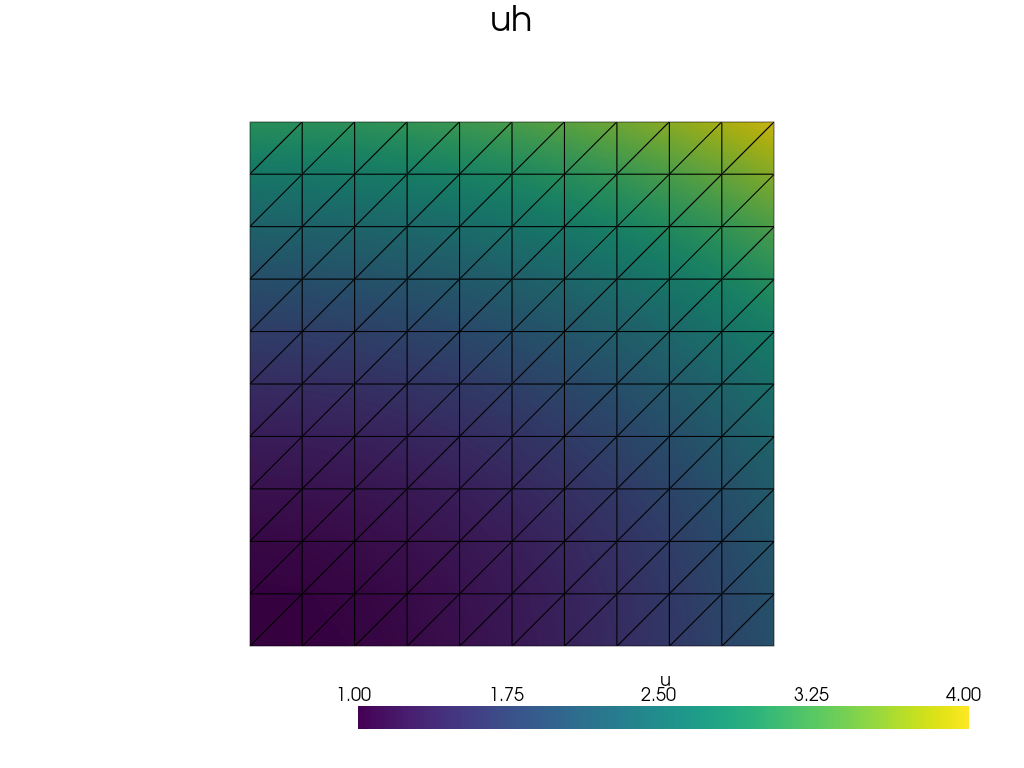

In [9]:
# Solve linear variational problem
a = lhs(F)
L = rhs(F)
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Visualize solution
pyvista.start_xvfb()
pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("robin_neumann_dirichlet.png")

## Verification
As for the previous problems, we compute the error of our computed solution and compare it to the analytical solution.

In [10]:
# Compute L2 error and error at nodes
V_ex = FunctionSpace(mesh, ("Lagrange", 2))
u_exact = Function(V_ex)
u_exact.interpolate(u_ex)
error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(form((uh - u_exact)**2 * dx)), op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(u_ex)
u_ex_vertex_values = uex_1.x.array
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = mesh.comm.allreduce(error_max, op=MPI.MAX)
print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 4.86e-03
Error_max : 2.07e-03
